In [14]:
# %%
# 单元格 1: 配置环境
# 运行此单元格将安装 (或更新) ASE 和 Matplotlib (用于绘图)
print("正在安装 ASE 和 Matplotlib...")
!pip install --upgrade ase matplotlib
print("安装完成！")


正在安装 ASE 和 Matplotlib...
安装完成！


In [15]:
# %%
# 单元格 2: 导入必要的库
import matplotlib.pyplot as plt
from ase.build import bulk, fcc111, add_adsorbate, molecule # <--- 在这里添加 molecule
from ase.io import read, write
from ase.visualize.plot import plot_atoms # 导入这个函数用于在 notebook 中绘图
from ase.calculators.emt import EMT # 导入 ASE 自带的 EMT 模拟器 (用于演示)
from ase.optimize import QuasiNewton # 导入一个优化算法
from ase.io import Trajectory # 导入轨迹文件工具

# 设置 matplotlib 在 notebook 中内联显示
%matplotlib inline

print("ASE 核心库导入成功！准备开始。")


ASE 核心库导入成功！准备开始。


--- 铜 (Cu) 块状晶体 Atoms 对象 ---
Atoms(symbols='Cu', pbc=True, cell=[[0.0, 1.8, 1.8], [1.8, 0.0, 1.8], [1.8, 1.8, 0.0]])
晶胞参数:
Cell([[0.0, 1.8, 1.8], [1.8, 0.0, 1.8], [1.8, 1.8, 0.0]])
是否为周期性: [ True  True  True]


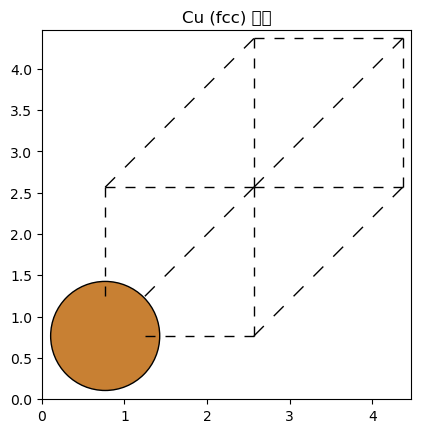

In [16]:
# %%
# 单元格 3: 1. ASE的核心 - Atoms 对象
# 让我们从零创建一个 块状(bulk) 铜(Cu) 晶体
# 'fcc'是面心立方, a=3.6是晶格常数
cu_bulk = bulk('Cu', 'fcc', a=3.6) 

# Atoms 对象包含了所有信息
print("--- 铜 (Cu) 块状晶体 Atoms 对象 ---")
print(cu_bulk)
print(f"晶胞参数:\n{cu_bulk.cell}")
print(f"是否为周期性: {cu_bulk.pbc}")

# 可视化这个晶胞
fig, ax = plt.subplots()
plot_atoms(cu_bulk, ax, radii=0.5, rotation=('0x,0y,0z'))
ax.set_title("Cu (fcc) 晶胞")
plt.show()



--- 铜 (111) 表面 (2x2, 3层厚) ---
Atoms(symbols='Cu12', pbc=[True, True, False], cell=[[5.091168824543143, 0.0, 0.0], [2.5455844122715714, 4.409081537009721, 0.0], [0.0, 0.0, 18.156921938165304]], tags=...)
总原子数: 12


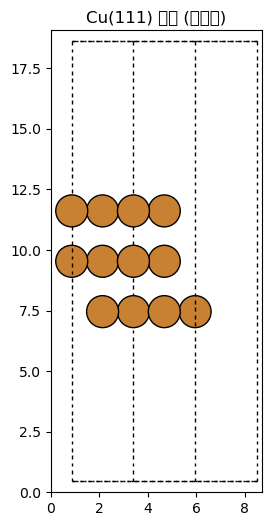

In [17]:
# %%
# 单元格 4: 2. 实战 - 搭建 (111) 表面
# 我们用 3 行代码，从上面的 "cu_bulk" 切割出一个 (111) 表面

# 1. 定义表面：fcc111('Cu', size=(2,2,3), vacuum=7.0)
# size=(2,2,3) 表示 2x2 的超胞，3层厚
# vacuum=7.0 表示在Z轴（上下）各加 7.0 埃的真空层
cu_surface = fcc111('Cu', size=(2,2,3), a=3.6, vacuum=7.0)

# 2. 看看这个表面
print("\n--- 铜 (111) 表面 (2x2, 3层厚) ---")
print(cu_surface)
print(f"总原子数: {len(cu_surface)}") # 2x2x3 = 12个原子

# 3. 可视化（侧视图）
fig, ax = plt.subplots(figsize=(6, 6))
# 沿x轴旋转90度，变成侧视图，方便观察真空层
plot_atoms(cu_surface, ax, radii=0.5, rotation=('-90x,0y,0z')) 
ax.set_title("Cu(111) 表面 (侧视图)")
plt.show()


--- CO 分子 Atoms 对象 ---
Atoms(symbols='OC', pbc=False)

--- CO on Cu(111) 表面 ---
Atoms(symbols='Cu12OC', pbc=[True, True, False], cell=[[5.091168824543143, 0.0, 0.0], [2.5455844122715714, 4.409081537009721, 0.0], [0.0, 0.0, 18.156921938165304]], tags=...)
总原子数: 14


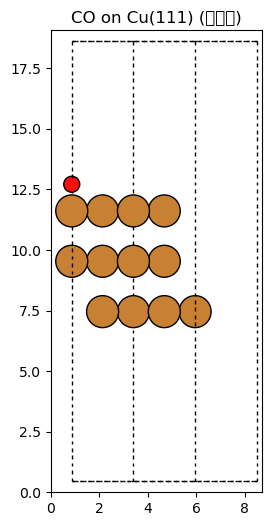

In [18]:
# %%
# 单元格 5: 3. 实战 - 添加吸附质 (CO)
# 我们用几行代码，在 "cu_surface" 的 "顶位" (ontop) 添加一个CO分子

# 1. 首先，用 ase.build.molecule 创建一个 CO 分子对象
co_molecule = molecule('CO')
# 我们可以打印看看它，它也是一个 Atoms 对象
print("--- CO 分子 Atoms 对象 ---")
print(co_molecule)

# 2. 定义吸附质 'co_molecule'，高度(height)=1.1埃，位置 'ontop'
# ASE 会自动找到最表面的Cu原子并放置在它正上方
add_adsorbate(cu_surface, co_molecule, height=1.1, position='ontop')

# 3. 看看加了吸附质的结构
print("\n--- CO on Cu(111) 表面 ---")
print(cu_surface)
print(f"总原子数: {len(cu_surface)}") # 原子数增加2 (C 和 O)，变为 14

# 3. 可视化（侧视图）
fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(cu_surface, ax, radii=0.5, rotation=('-90x,0y,0z'))
ax.set_title("CO on Cu(111) (侧视图)")
plt.show()


In [20]:
# %%
# 单元格 6: 4. 实战 - 连接“计算器”并获取能量
# (在真实科研中，你会把 EMT() 换成 Vasp(), QE() 等)

# 1. 把“计算器”和我们的“结构”绑定
cu_surface.calc = EMT()

# 2. “指挥”计算器去计算这个结构的总能量
potential_energy = cu_surface.get_potential_energy()

print(f"\n--- 计算完成 ---")
print(f"结构 (CO on Cu(111)) 的总能量 (EMT): {potential_energy:.4f} eV")

# 3. 顺便获取一下原子受力
forces = cu_surface.get_forces()
print(f"\n查看最后一个原子(O)受力: {forces[-1]}")



--- 计算完成 ---
结构 (CO on Cu(111)) 的总能量 (EMT): 286.1787 eV

查看最后一个原子(O)受力: [-1.27597043e-17 -3.78603399e-16 -7.94434117e+02]



--- 开始结构优化 (弛豫) ... ---
                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 06:02:30      286.178711     794.4341
BFGSLineSearch:    1[  1] 06:02:30      112.284700     266.8711
BFGSLineSearch:    2[  3] 06:02:30       74.168946     228.2893
BFGSLineSearch:    3[  5] 06:02:30       22.089455      70.0765
BFGSLineSearch:    4[  7] 06:02:30        9.497482      21.7940
BFGSLineSearch:    5[  8] 06:02:30        6.643158      15.7415
BFGSLineSearch:    6[  9] 06:02:30        5.436827      10.4225
BFGSLineSearch:    7[ 10] 06:02:30        4.739561       6.5705
BFGSLineSearch:    8[ 11] 06:02:30        4.413506       4.5279
BFGSLineSearch:    9[ 12] 06:02:30        4.256575       3.4261
BFGSLineSearch:   10[ 14] 06:02:30        4.092519       2.1839
BFGSLineSearch:   11[ 16] 06:02:30        3.829887       0.3802
BFGSLineSearch:   12[ 17] 06:02:30        3.788852       0.3096
BFGSLineSearch:   13[ 18] 06:02:30        3.782802       0.3178
BFGSLineSearch

c:\Users\hpf_2\.conda\envs\matsci_ai\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hpf_2\.conda\envs\matsci_ai\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hpf_2\.conda\envs\matsci_ai\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hpf_2\.conda\envs\matsci_ai\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


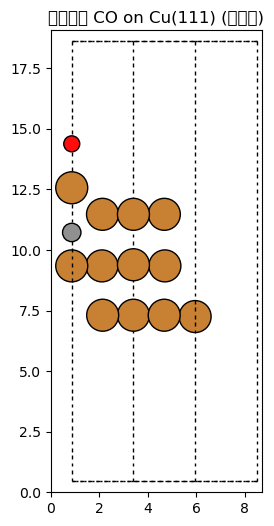


--- 恭喜你完成了ASE入门！---
提示：在您的本地终端 (Terminal) 中，您可以运行 `ase gui co_cu_relaxation.traj` 来播放整个弛豫过程的“动画”！


In [21]:
# %%
# 单元格 7: 5. 实战 - 运行模拟 (结构优化) 与可视化
# 让我们对这个 CO/Cu(111) 体系做一个简单的“结构弛豫”

# 1. 定义优化器，并告诉它要优化哪个结构
# (cu_surface 已经绑定了 EMT 计算器)
optimizer = QuasiNewton(cu_surface)

# 2. 定义一个轨迹文件，用于保存优化的“动画”
traj_filename = "co_cu_relaxation.traj"
traj = Trajectory(traj_filename, 'w', cu_surface) # 'w' = write

# 3. 把优化器和轨迹文件连接起来
optimizer.attach(traj)

# 4. 运行优化！(fmax=0.05 是收敛标准，即最大受力小于 0.05 eV/Å)
print("\n--- 开始结构优化 (弛豫) ... ---")
optimizer.run(fmax=0.05)
print("--- 优化完成！---")

# 5. 读取轨迹文件，并可视化“最后一帧”（优化后的结构）
final_structure = read(traj_filename, index=-1) # index=-1 表示最后一张

print(f"\n优化前的总能量: {potential_energy:.4f} eV")
print(f"优化后的总能量: {final_structure.get_potential_energy():.4f} eV")

fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(final_structure, ax, radii=0.5, rotation=('-90x,0y,0z'))
ax.set_title("优化后的 CO on Cu(111) (侧视图)")
plt.show()

print("\n--- 恭喜你完成了ASE入门！---")
print(f"提示：在您的本地终端 (Terminal) 中，您可以运行 `ase gui {traj_filename}` 来播放整个弛豫过程的“动画”！")
